In [ ]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 2.6 MB/s eta 0:00:00


In [ ]:
pip install xgboost

In [ ]:
import numpy as np
import pandas as pd
import time
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import BaggingClassifier, VotingClassifier
from imblearn.over_sampling import ADASYN
from joblib import Parallel, delayed
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
def train_classifier(i, x, y):
    classifiers_list[i].fit(x, y)
    return classifiers_list[i]

In [ ]:
def allocate_classifier():
  return DecisionTreeClassifier()

In [ ]:
datainput = pd.read_csv('/content/drive/MyDrive/dmt_proj/creditcard.csv')

In [ ]:
# missing values
datainput = datainput.fillna(datainput.mean())

In [ ]:
print(len(datainput))

284807


In [ ]:
adasyn = ADASYN()
X_resampled, y_resampled = adasyn.fit_resample(datainput.drop(columns=['Class']), datainput['Class'])
datainput = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled, columns=['Class'])], axis=1)

In [ ]:
# Scale features
scaler = StandardScaler()
datainput.iloc[:, :-1] = scaler.fit_transform(datainput.iloc[:, :-1])  # Scale all features except target

In [ ]:
valid=datainput[datainput['Class']==0]
fraud=datainput[datainput['Class']==1]

In [ ]:
print(len(valid),len(fraud),(len(fraud)/len(valid)))

284315 492 0.0017304750013189597


In [ ]:
class_balance= True if (len(fraud)/len(valid))>=.90 else False

In [ ]:
print(class_balance)

False


In [ ]:
n=int(input("Fraction:"))

Fraction:30


In [ ]:
fraud_test = fraud.sample(frac=n/100, random_state=42)
fraud = fraud.drop(fraud_test.index)

In [ ]:
valid_test = valid.sample(frac=len(fraud_test)/len(valid), random_state=42)
valid = valid.drop(valid_test.index)

In [ ]:
print(len(valid_test),len(fraud_test))

148 148


In [ ]:
print(len(valid),len(fraud))

284167 344


In [ ]:
train_list = []
global classifiers_list
classifiers_list=[]
i=0
if class_balance:
  fraud_train_size=1000
  limit=(len(valid)//1000)
  while i<limit:
    valid_subset = valid.sample(n=fraud_train_size)
    valid = valid.drop(valid_subset.index)
    fraud_subset = fraud.sample(n=fraud_train_size)
    fraud = fraud.drop(fraud_subset.index)
    train_list.append(pd.concat([valid_subset, fraud_subset]))
    classifiers_list.append(allocate_classifier())
    i+=1

  if len(valid)>0 and len(fraud)>0:
    train_list.append(pd.concat([valid,fraud]))
    classifiers_list.append(allocate_classifier())
else:
  fraud_train_size=len(fraud)
  limit=(len(valid)//len(fraud))
  while i<limit:
      subset = valid.sample(n=fraud_train_size)
      valid = valid.drop(subset.index)
      train_list.append(subset)
      classifiers_list.append(allocate_classifier())
      i+=1

  for i in range(len(train_list)):
      train_list[i] = pd.concat([fraud, train_list[i]])

  if len(valid)>0:
      last_piece=fraud.sample(n=len(valid))
      train_list.append(pd.concat([valid,last_piece]))
      classifiers_list.append(allocate_classifier())

KeyboardInterrupt: 

In [ ]:
len(train_list),len(train_list[0]),len(classifiers_list)

(827, 688, 827)

In [ ]:
len(train_list),len(train_list[0]),len(classifiers_list)

In [ ]:
test = pd.concat([fraud_test, valid_test])

In [ ]:
X_test=test.iloc[:,:-1].values
Y_test=test.iloc[:, -1].values

In [ ]:
# Initialize a list to store predictions
pred = []
for i in range(len(classifiers_list)):
    pred.append(classifiers_list[i].predict(X_test))

In [ ]:
Y_pred=[]
for i in range(len(pred[0])):
    temp=[]
    for j in pred:
        temp.append(j[i])
    Y_pred.append([1 if temp.count(1)>temp.count(0) else 0])

In [ ]:
accuracy = accuracy_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)
auc_roc = roc_auc_score(Y_test, Y_pred)

In [ ]:
print(f"Accuracy: {accuracy*100:.2f}% Precision: {precision*100:.2f}% Recall: {recall*100:.2f}% F1 Score: {f1*100:.2f}% AUC-ROC: {auc_roc*100:.4f}")

Accuracy: 94.93% Precision: 95.86% Recall: 93.92% F1 Score: 94.88% AUC-ROC: 94.9324


In [ ]:
print(n)

30


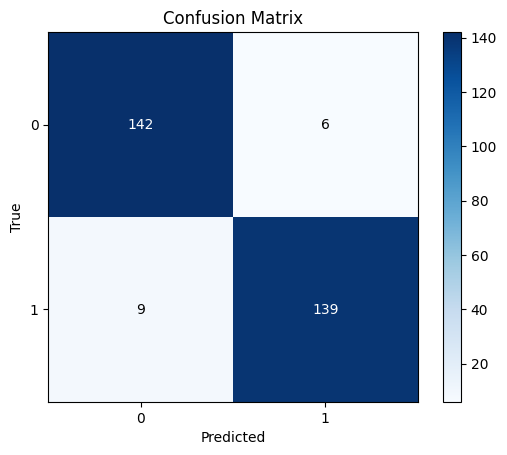

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute TP, TN, FP, and FN
cm = confusion_matrix(Y_test, Y_pred)

# Display the confusion matrix as an image
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add labels and values to the confusion matrix
classes = ['0', '1']
for i, row in enumerate(cm):
    for j, value in enumerate(row):
        plt.text(j, i, value, ha="center", va="center", color="white" if value > cm.max() / 2 else "black")

plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks([0, 1], classes)
plt.yticks([0, 1], classes)

# Show the plot
plt.show()

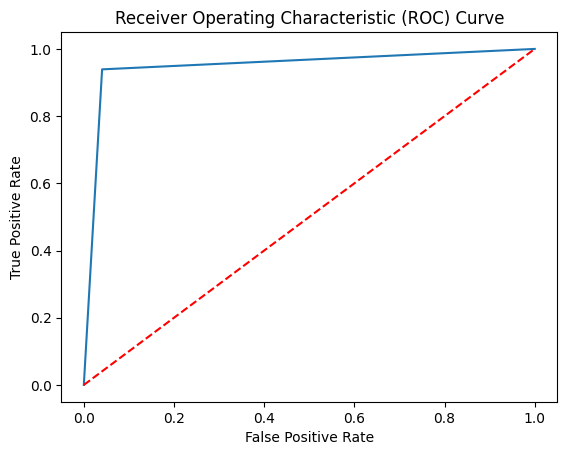

AUC: 94.93243243243242


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute FPR and TPR at various threshold settings
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)

# Compute AUC
auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

# Print AUC
print('AUC:', auc*100)

In [ ]:
# %%
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
# %%
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [ ]:
classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    CatBoostClassifier(),
    BaggingClassifier(),
    AdaBoostClassifier(),
    SVC(),
    KNeighborsClassifier(),
]

In [ ]:
for classifier in classifiers:
  print(classifier)
  for n in range(10,51,10):
    datainput=pd.read_csv('/content/drive/MyDrive/dmt_proj/creditcard.csv')

    datainput = datainput.fillna(datainput.mean())

    #adasyn = ADASYN()
    #X_resampled, y_resampled = adasyn.fit_resample(datainput.drop(columns=['Class']), datainput['Class'])
    #datainput = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled, columns=['Class'])], axis=1)

    scaler = StandardScaler()
    datainput.iloc[:, :-1] = scaler.fit_transform(datainput.iloc[:, :-1])

    valid=datainput[datainput['Class']==0]
    fraud=datainput[datainput['Class']==1]

    class_balance= True if (len(fraud)/len(valid))>=.90 else False

    # %%
    fraud_test = fraud.sample(frac=n/100, random_state=42)
    fraud = fraud.drop(fraud_test.index)
    valid_test = valid.sample(frac=len(fraud_test)/len(valid), random_state=42)
    valid = valid.drop(valid_test.index)

    # %%
    train_list = []
    global classifiers_list
    classifiers_list=[]
    i=0
    if class_balance:
      fraud_train_size=1000
      limit=(len(valid)//1000)
      while i<limit:
        valid_subset = valid.sample(n=fraud_train_size)
        valid = valid.drop(valid_subset.index)
        fraud_subset = fraud.sample(n=fraud_train_size)
        fraud = fraud.drop(fraud_subset.index)
        train_list.append(pd.concat([valid_subset, fraud_subset]))
        classifiers_list.append(allocate_classifier())
        i+=1
      if len(valid)>0 and len(fraud)>0:
          train_list.append(pd.concat([valid,fraud]))
          classifiers_list.append(allocate_classifier())
    else:
      fraud_train_size=len(fraud)
      limit=(len(valid)//len(fraud))
      while i<limit:
          subset = valid.sample(n=fraud_train_size)
          valid = valid.drop(subset.index)
          train_list.append(subset)
          classifiers_list.append(allocate_classifier())
          i+=1
      for i in range(len(train_list)):
          train_list[i] = pd.concat([fraud, train_list[i]])
      if len(valid)>0:
          last_piece=fraud.sample(n=len(valid))
          train_list.append(pd.concat([valid,last_piece]))
          classifiers_list.append(allocate_classifier())

    # %%
    # Parallel training of classifiers
    classifiers_list=Parallel(n_jobs=-1)(delayed(train_classifier)(i, train_list[i].iloc[:,:-1].values, train_list[i].iloc[:, -1].values) for i in range(len(classifiers_list)))

    # %%
    test=pd.concat([fraud_test,valid_test])

    # %%
    X_test=test.iloc[:,:-1].values
    Y_test=test.iloc[:, -1].values

    # %%
    # Initialize a list to store predictions
    pred = []
    for i in range(len(classifiers_list)):
        pred.append(classifiers_list[i].predict(X_test))

    # %%
    Y_pred=[]
    for i in range(len(pred[0])):
        temp=[]
        for j in pred:
            temp.append(j[i])
        Y_pred.append([1 if temp.count(1)>temp.count(0) else 0])

    # %%
    accuracy = accuracy_score(Y_test, Y_pred)
    precision = precision_score(Y_test, Y_pred)
    recall = recall_score(Y_test, Y_pred)
    f1 = f1_score(Y_test, Y_pred)
    auc_roc = roc_auc_score(Y_test, Y_pred)

    # %%
    # Print evaluation metrics
    print(n)
    print(f"Accuracy: {accuracy*100:.2f}% Precision: {precision*100:.2f}% Recall: {recall*100:.2f}% F1 Score: {f1*100:.2f}% AUC-ROC: {auc_roc*100:.4f}")


DecisionTreeClassifier()
10
Accuracy: 93.88% Precision: 92.16% Recall: 95.92% F1 Score: 94.00% AUC-ROC: 93.8776
20
Accuracy: 94.90% Precision: 94.90% Recall: 94.90% F1 Score: 94.90% AUC-ROC: 94.8980
30
Accuracy: 94.59% Precision: 95.21% Recall: 93.92% F1 Score: 94.56% AUC-ROC: 94.5946
40
Accuracy: 94.67% Precision: 96.32% Recall: 92.89% F1 Score: 94.57% AUC-ROC: 94.6701
50
Accuracy: 94.11% Precision: 96.17% Recall: 91.87% F1 Score: 93.97% AUC-ROC: 94.1057
RandomForestClassifier()
10
Accuracy: 94.90% Precision: 92.31% Recall: 97.96% F1 Score: 95.05% AUC-ROC: 94.8980
20
Accuracy: 94.39% Precision: 94.85% Recall: 93.88% F1 Score: 94.36% AUC-ROC: 94.3878
30
Accuracy: 94.93% Precision: 95.86% Recall: 93.92% F1 Score: 94.88% AUC-ROC: 94.9324
40
Accuracy: 94.67% Precision: 96.32% Recall: 92.89% F1 Score: 94.57% AUC-ROC: 94.6701
50
Accuracy: 94.31% Precision: 96.19% Recall: 92.28% F1 Score: 94.19% AUC-ROC: 94.3089
GradientBoostingClassifier()
10
Accuracy: 93.88% Precision: 92.16% Recall: 95.92